# Object detection with Keras and TS

- Documentation : https://www.tensorflow.org/hub/tutorials/object_detection?hl=fr

## Setup

In [2]:
%pip install -q tflite-model-maker
%pip install -q tflite-support
%pip install opencv-python-headless==4.5.2.52
!pip3 install pycocotools



try:
# pylint: disable=g-import-not-at-top
  from pycocotools.coco import COCO
  from pycocotools.cocoeval import COCOeval
# pylint: enable=g-import-not-at-top
except ImportError:
  print('Erreur')


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

2024-04-14 11:07:14.769541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-14 11:07:14.769584: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/charles/web/alyra/villepropre/vp-server/.venv/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/charles/web/alyra/villepropre/vp-server/.venv/lib

## Chargement du jeu de données

In [4]:
train_folder = 'datasets/dataset.voc/train'
val_folder = 'datasets/dataset.voc/valid'
test_folder = 'datasets/dataset.voc/test'

# These images are used to train the object detection model to recognize plastic and can
train_data = object_detector.DataLoader.from_pascal_voc(
    train_folder,
    train_folder,
    ['plastique','canette']
)

# These images are used to evaluate the model. 
# These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid overfitting.
val_data = object_detector.DataLoader.from_pascal_voc(
    val_folder,
    val_folder,
    # label_map={1: "plastique", 2: "canette"}
    ['plastique','canette']
)

# These images are used to evaluate the final model performance.
test_data = object_detector.DataLoader.from_pascal_voc(
    test_folder,
    test_folder,
    ['plastique','canette']
)

## Mise en cache des données

In [5]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Selection du modèle

In [6]:
# Liste des modèles possibles : https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/model_spec
# spec = model_spec.get('mobilenet_v2')
# spec = model_spec.get('efficientdet_lite4')

verbose=1
tflite_max_detections=2

spec = model_spec.get('efficientdet_lite3')
spec.tflite_max_detections=tflite_max_detections
spec.verbose=verbose


2024-04-14 11:07:21.080668: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-14 11:07:21.080725: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-14 11:07:21.080792: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-R17EPGM): /proc/driver/nvidia/version does not exist
2024-04-14 11:07:21.081285: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Entrainement du modèle

In [7]:
# Entraîner entièrement le modèle (fine-tuning) ?
train_whole_model=True
epochs=50
batch_size=5
model = object_detector.create(train_data, 
                               validation_data=val_data,
                               model_spec=spec, 
                               train_whole_model=train_whole_model,
                               epochs=epochs,
                               batch_size=batch_size
                               )


Epoch 1/80


2024-04-14 11:07:47.852644: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - ETA: 0s - det_loss: 1.7066 - cls_loss: 1.1134 - box_loss: 0.0119 - reg_l2_loss: 0.0925 - loss: 1.7992 - learning_rate: 0.0072 - gradient_norm: 1.1739

2024-04-14 11:10:39.078149: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 185s 7s/step - det_loss: 1.6971 - cls_loss: 1.1100 - box_loss: 0.0117 - reg_l2_loss: 0.0925 - loss: 1.7896 - learning_rate: 0.0071 - gradient_norm: 1.1771 - val_det_loss: 1.4231 - val_cls_loss: 1.0174 - val_box_loss: 0.0081 - val_reg_l2_loss: 0.0925 - val_loss: 1.5156
Epoch 2/80
21/21 [==============================] - ETA: 0s - det_loss: 1.3683 - cls_loss: 0.9258 - box_loss: 0.0089 - reg_l2_loss: 0.0925 - loss: 1.4609 - learning_rate: 0.0062 - gradient_norm: 2.4138

2024-04-14 11:13:13.357691: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 152s 7s/step - det_loss: 1.3524 - cls_loss: 0.9154 - box_loss: 0.0087 - reg_l2_loss: 0.0925 - loss: 1.4450 - learning_rate: 0.0062 - gradient_norm: 2.4156 - val_det_loss: 1.2953 - val_cls_loss: 0.9693 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0926 - val_loss: 1.3878
Epoch 3/80
21/21 [==============================] - ETA: 0s - det_loss: 0.9957 - cls_loss: 0.6348 - box_loss: 0.0072 - reg_l2_loss: 0.0926 - loss: 1.0883 - learning_rate: 0.0062 - gradient_norm: 3.6096

2024-04-14 11:15:16.929317: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 120s 6s/step - det_loss: 0.9820 - cls_loss: 0.6268 - box_loss: 0.0071 - reg_l2_loss: 0.0926 - loss: 1.0746 - learning_rate: 0.0062 - gradient_norm: 3.5557 - val_det_loss: 0.9519 - val_cls_loss: 0.6101 - val_box_loss: 0.0068 - val_reg_l2_loss: 0.0926 - val_loss: 1.0445
Epoch 4/80
21/21 [==============================] - ETA: 0s - det_loss: 0.7460 - cls_loss: 0.4636 - box_loss: 0.0056 - reg_l2_loss: 0.0926 - loss: 0.8386 - learning_rate: 0.0062 - gradient_norm: 3.6209

2024-04-14 11:17:13.705416: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 116s 6s/step - det_loss: 0.7470 - cls_loss: 0.4627 - box_loss: 0.0057 - reg_l2_loss: 0.0926 - loss: 0.8396 - learning_rate: 0.0062 - gradient_norm: 3.5767 - val_det_loss: 0.8542 - val_cls_loss: 0.5269 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0926 - val_loss: 0.9468
Epoch 5/80
21/21 [==============================] - ETA: 0s - det_loss: 0.6522 - cls_loss: 0.4117 - box_loss: 0.0048 - reg_l2_loss: 0.0926 - loss: 0.7448 - learning_rate: 0.0062 - gradient_norm: 3.8184

2024-04-14 11:19:11.473555: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 135s 6s/step - det_loss: 0.6523 - cls_loss: 0.4118 - box_loss: 0.0048 - reg_l2_loss: 0.0926 - loss: 0.7450 - learning_rate: 0.0062 - gradient_norm: 4.0015 - val_det_loss: 0.7728 - val_cls_loss: 0.4398 - val_box_loss: 0.0067 - val_reg_l2_loss: 0.0926 - val_loss: 0.8654
Epoch 6/80
21/21 [==============================] - ETA: 0s - det_loss: 0.6417 - cls_loss: 0.3997 - box_loss: 0.0048 - reg_l2_loss: 0.0926 - loss: 0.7343 - learning_rate: 0.0062 - gradient_norm: 4.3443

2024-04-14 11:21:26.300844: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 117s 6s/step - det_loss: 0.6428 - cls_loss: 0.4004 - box_loss: 0.0048 - reg_l2_loss: 0.0926 - loss: 0.7354 - learning_rate: 0.0062 - gradient_norm: 4.4524 - val_det_loss: 0.6924 - val_cls_loss: 0.3984 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0926 - val_loss: 0.7850
Epoch 7/80
21/21 [==============================] - ETA: 0s - det_loss: 0.5620 - cls_loss: 0.3524 - box_loss: 0.0042 - reg_l2_loss: 0.0926 - loss: 0.6546 - learning_rate: 0.0061 - gradient_norm: 4.2081

2024-04-14 11:23:21.534402: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 115s 6s/step - det_loss: 0.5711 - cls_loss: 0.3569 - box_loss: 0.0043 - reg_l2_loss: 0.0926 - loss: 0.6638 - learning_rate: 0.0061 - gradient_norm: 4.4713 - val_det_loss: 0.6643 - val_cls_loss: 0.3644 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0927 - val_loss: 0.7569
Epoch 8/80
21/21 [==============================] - ETA: 0s - det_loss: 0.5370 - cls_loss: 0.3461 - box_loss: 0.0038 - reg_l2_loss: 0.0927 - loss: 0.6296 - learning_rate: 0.0061 - gradient_norm: 3.7948

2024-04-14 11:25:14.470346: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 113s 5s/step - det_loss: 0.5360 - cls_loss: 0.3435 - box_loss: 0.0038 - reg_l2_loss: 0.0927 - loss: 0.6287 - learning_rate: 0.0061 - gradient_norm: 3.7488 - val_det_loss: 0.6005 - val_cls_loss: 0.3575 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0927 - val_loss: 0.6931
Epoch 9/80
21/21 [==============================] - ETA: 0s - det_loss: 0.5176 - cls_loss: 0.3302 - box_loss: 0.0037 - reg_l2_loss: 0.0927 - loss: 0.6103 - learning_rate: 0.0061 - gradient_norm: 3.6813

2024-04-14 11:27:03.972909: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.5188 - cls_loss: 0.3320 - box_loss: 0.0037 - reg_l2_loss: 0.0927 - loss: 0.6115 - learning_rate: 0.0061 - gradient_norm: 3.6245 - val_det_loss: 0.6301 - val_cls_loss: 0.3716 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0927 - val_loss: 0.7228
Epoch 10/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4662 - cls_loss: 0.3100 - box_loss: 0.0031 - reg_l2_loss: 0.0927 - loss: 0.5589 - learning_rate: 0.0060 - gradient_norm: 3.5969

2024-04-14 11:28:49.219807: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 111s 5s/step - det_loss: 0.4645 - cls_loss: 0.3097 - box_loss: 0.0031 - reg_l2_loss: 0.0927 - loss: 0.5572 - learning_rate: 0.0060 - gradient_norm: 3.5755 - val_det_loss: 0.6006 - val_cls_loss: 0.3590 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0927 - val_loss: 0.6933
Epoch 11/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4506 - cls_loss: 0.2833 - box_loss: 0.0033 - reg_l2_loss: 0.0927 - loss: 0.5433 - learning_rate: 0.0060 - gradient_norm: 3.1408

2024-04-14 11:30:47.027855: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 116s 6s/step - det_loss: 0.4481 - cls_loss: 0.2806 - box_loss: 0.0034 - reg_l2_loss: 0.0927 - loss: 0.5408 - learning_rate: 0.0060 - gradient_norm: 3.1208 - val_det_loss: 0.5903 - val_cls_loss: 0.3351 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0927 - val_loss: 0.6830
Epoch 12/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4395 - cls_loss: 0.2816 - box_loss: 0.0032 - reg_l2_loss: 0.0927 - loss: 0.5322 - learning_rate: 0.0059 - gradient_norm: 3.5683

2024-04-14 11:32:36.618638: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 106s 5s/step - det_loss: 0.4367 - cls_loss: 0.2811 - box_loss: 0.0031 - reg_l2_loss: 0.0927 - loss: 0.5295 - learning_rate: 0.0059 - gradient_norm: 3.4997 - val_det_loss: 0.6550 - val_cls_loss: 0.3236 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.0927 - val_loss: 0.7477
Epoch 13/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4373 - cls_loss: 0.2677 - box_loss: 0.0034 - reg_l2_loss: 0.0927 - loss: 0.5300 - learning_rate: 0.0059 - gradient_norm: 3.5588

2024-04-14 11:34:22.315933: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 105s 5s/step - det_loss: 0.4381 - cls_loss: 0.2698 - box_loss: 0.0034 - reg_l2_loss: 0.0927 - loss: 0.5308 - learning_rate: 0.0059 - gradient_norm: 3.5706 - val_det_loss: 0.5983 - val_cls_loss: 0.3213 - val_box_loss: 0.0055 - val_reg_l2_loss: 0.0927 - val_loss: 0.6910
Epoch 14/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4539 - cls_loss: 0.2849 - box_loss: 0.0034 - reg_l2_loss: 0.0928 - loss: 0.5467 - learning_rate: 0.0058 - gradient_norm: 4.0035

2024-04-14 11:36:05.867820: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.4503 - cls_loss: 0.2828 - box_loss: 0.0034 - reg_l2_loss: 0.0928 - loss: 0.5431 - learning_rate: 0.0058 - gradient_norm: 3.9952 - val_det_loss: 0.6209 - val_cls_loss: 0.3313 - val_box_loss: 0.0058 - val_reg_l2_loss: 0.0928 - val_loss: 0.7136
Epoch 15/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3906 - cls_loss: 0.2427 - box_loss: 0.0030 - reg_l2_loss: 0.0928 - loss: 0.4833 - learning_rate: 0.0057 - gradient_norm: 3.6304

2024-04-14 11:37:48.119919: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.3902 - cls_loss: 0.2441 - box_loss: 0.0029 - reg_l2_loss: 0.0928 - loss: 0.4830 - learning_rate: 0.0057 - gradient_norm: 3.6817 - val_det_loss: 0.6255 - val_cls_loss: 0.3314 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0928 - val_loss: 0.7183
Epoch 16/80
21/21 [==============================] - ETA: 0s - det_loss: 0.4124 - cls_loss: 0.2536 - box_loss: 0.0032 - reg_l2_loss: 0.0928 - loss: 0.5052 - learning_rate: 0.0057 - gradient_norm: 4.0686

2024-04-14 11:39:38.570609: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 105s 5s/step - det_loss: 0.4076 - cls_loss: 0.2507 - box_loss: 0.0031 - reg_l2_loss: 0.0928 - loss: 0.5004 - learning_rate: 0.0057 - gradient_norm: 3.9731 - val_det_loss: 0.6224 - val_cls_loss: 0.3346 - val_box_loss: 0.0058 - val_reg_l2_loss: 0.0928 - val_loss: 0.7152
Epoch 17/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3991 - cls_loss: 0.2497 - box_loss: 0.0030 - reg_l2_loss: 0.0928 - loss: 0.4919 - learning_rate: 0.0056 - gradient_norm: 3.4056

2024-04-14 11:41:21.510609: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.4053 - cls_loss: 0.2523 - box_loss: 0.0031 - reg_l2_loss: 0.0928 - loss: 0.4981 - learning_rate: 0.0056 - gradient_norm: 3.4584 - val_det_loss: 0.6384 - val_cls_loss: 0.3445 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0928 - val_loss: 0.7312
Epoch 18/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3635 - cls_loss: 0.2244 - box_loss: 0.0028 - reg_l2_loss: 0.0928 - loss: 0.4563 - learning_rate: 0.0055 - gradient_norm: 3.3159

2024-04-14 11:43:01.093326: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 101s 5s/step - det_loss: 0.3641 - cls_loss: 0.2247 - box_loss: 0.0028 - reg_l2_loss: 0.0928 - loss: 0.4569 - learning_rate: 0.0055 - gradient_norm: 3.3800 - val_det_loss: 0.5672 - val_cls_loss: 0.3275 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0928 - val_loss: 0.6600
Epoch 19/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3651 - cls_loss: 0.2268 - box_loss: 0.0028 - reg_l2_loss: 0.0928 - loss: 0.4579 - learning_rate: 0.0054 - gradient_norm: 3.2081

2024-04-14 11:44:47.974988: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 106s 5s/step - det_loss: 0.3655 - cls_loss: 0.2277 - box_loss: 0.0028 - reg_l2_loss: 0.0928 - loss: 0.4583 - learning_rate: 0.0054 - gradient_norm: 3.1837 - val_det_loss: 0.4310 - val_cls_loss: 0.2541 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0928 - val_loss: 0.5238
Epoch 20/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3600 - cls_loss: 0.2278 - box_loss: 0.0026 - reg_l2_loss: 0.0928 - loss: 0.4528 - learning_rate: 0.0054 - gradient_norm: 3.4090

2024-04-14 11:46:31.669938: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 110s 5s/step - det_loss: 0.3615 - cls_loss: 0.2296 - box_loss: 0.0026 - reg_l2_loss: 0.0928 - loss: 0.4543 - learning_rate: 0.0054 - gradient_norm: 3.3420 - val_det_loss: 0.4631 - val_cls_loss: 0.2872 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0928 - val_loss: 0.5560
Epoch 21/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3450 - cls_loss: 0.2184 - box_loss: 0.0025 - reg_l2_loss: 0.0928 - loss: 0.4378 - learning_rate: 0.0053 - gradient_norm: 3.2897

2024-04-14 11:48:21.824336: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.3437 - cls_loss: 0.2179 - box_loss: 0.0025 - reg_l2_loss: 0.0928 - loss: 0.4365 - learning_rate: 0.0053 - gradient_norm: 3.2287 - val_det_loss: 0.6180 - val_cls_loss: 0.3830 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0928 - val_loss: 0.7109
Epoch 22/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3227 - cls_loss: 0.2088 - box_loss: 0.0023 - reg_l2_loss: 0.0928 - loss: 0.4155 - learning_rate: 0.0052 - gradient_norm: 2.8427

2024-04-14 11:50:06.242751: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 106s 5s/step - det_loss: 0.3241 - cls_loss: 0.2097 - box_loss: 0.0023 - reg_l2_loss: 0.0928 - loss: 0.4169 - learning_rate: 0.0052 - gradient_norm: 2.9166 - val_det_loss: 0.5967 - val_cls_loss: 0.3414 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0928 - val_loss: 0.6895
Epoch 23/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3200 - cls_loss: 0.2029 - box_loss: 0.0023 - reg_l2_loss: 0.0929 - loss: 0.4129 - learning_rate: 0.0051 - gradient_norm: 3.4957

2024-04-14 11:51:51.638015: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.3173 - cls_loss: 0.2014 - box_loss: 0.0023 - reg_l2_loss: 0.0929 - loss: 0.4101 - learning_rate: 0.0051 - gradient_norm: 3.4430 - val_det_loss: 0.5435 - val_cls_loss: 0.3301 - val_box_loss: 0.0043 - val_reg_l2_loss: 0.0929 - val_loss: 0.6364
Epoch 24/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3763 - cls_loss: 0.2324 - box_loss: 0.0029 - reg_l2_loss: 0.0929 - loss: 0.4692 - learning_rate: 0.0050 - gradient_norm: 4.5779

2024-04-14 11:53:33.865283: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.3734 - cls_loss: 0.2312 - box_loss: 0.0028 - reg_l2_loss: 0.0929 - loss: 0.4662 - learning_rate: 0.0050 - gradient_norm: 4.4524 - val_det_loss: 0.5509 - val_cls_loss: 0.3393 - val_box_loss: 0.0042 - val_reg_l2_loss: 0.0929 - val_loss: 0.6437
Epoch 25/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3522 - cls_loss: 0.2202 - box_loss: 0.0026 - reg_l2_loss: 0.0929 - loss: 0.4451 - learning_rate: 0.0049 - gradient_norm: 3.5044

2024-04-14 11:55:18.192584: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 110s 5s/step - det_loss: 0.3500 - cls_loss: 0.2192 - box_loss: 0.0026 - reg_l2_loss: 0.0929 - loss: 0.4429 - learning_rate: 0.0049 - gradient_norm: 3.4755 - val_det_loss: 0.5563 - val_cls_loss: 0.3521 - val_box_loss: 0.0041 - val_reg_l2_loss: 0.0929 - val_loss: 0.6492
Epoch 26/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3450 - cls_loss: 0.2156 - box_loss: 0.0026 - reg_l2_loss: 0.0929 - loss: 0.4379 - learning_rate: 0.0048 - gradient_norm: 3.4298

2024-04-14 11:57:07.149017: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.3425 - cls_loss: 0.2149 - box_loss: 0.0026 - reg_l2_loss: 0.0929 - loss: 0.4353 - learning_rate: 0.0048 - gradient_norm: 3.4018 - val_det_loss: 0.4370 - val_cls_loss: 0.2707 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0929 - val_loss: 0.5298
Epoch 27/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3508 - cls_loss: 0.2242 - box_loss: 0.0025 - reg_l2_loss: 0.0929 - loss: 0.4437 - learning_rate: 0.0047 - gradient_norm: 3.8109

2024-04-14 11:58:50.873735: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.3476 - cls_loss: 0.2222 - box_loss: 0.0025 - reg_l2_loss: 0.0929 - loss: 0.4405 - learning_rate: 0.0047 - gradient_norm: 3.7603 - val_det_loss: 0.4978 - val_cls_loss: 0.3202 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.0929 - val_loss: 0.5907
Epoch 28/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3320 - cls_loss: 0.2036 - box_loss: 0.0026 - reg_l2_loss: 0.0929 - loss: 0.4249 - learning_rate: 0.0046 - gradient_norm: 3.3104

2024-04-14 12:00:33.059595: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.3283 - cls_loss: 0.2013 - box_loss: 0.0025 - reg_l2_loss: 0.0929 - loss: 0.4212 - learning_rate: 0.0046 - gradient_norm: 3.2731 - val_det_loss: 0.4459 - val_cls_loss: 0.2783 - val_box_loss: 0.0034 - val_reg_l2_loss: 0.0929 - val_loss: 0.5388
Epoch 29/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3159 - cls_loss: 0.1974 - box_loss: 0.0024 - reg_l2_loss: 0.0929 - loss: 0.4088 - learning_rate: 0.0045 - gradient_norm: 3.4559

2024-04-14 12:02:15.468139: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.3141 - cls_loss: 0.1959 - box_loss: 0.0024 - reg_l2_loss: 0.0929 - loss: 0.4070 - learning_rate: 0.0044 - gradient_norm: 3.4111 - val_det_loss: 0.3884 - val_cls_loss: 0.2419 - val_box_loss: 0.0029 - val_reg_l2_loss: 0.0929 - val_loss: 0.4813
Epoch 30/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3177 - cls_loss: 0.2093 - box_loss: 0.0022 - reg_l2_loss: 0.0929 - loss: 0.4106 - learning_rate: 0.0043 - gradient_norm: 3.5886

2024-04-14 12:03:59.138460: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.3162 - cls_loss: 0.2086 - box_loss: 0.0022 - reg_l2_loss: 0.0929 - loss: 0.4091 - learning_rate: 0.0043 - gradient_norm: 3.5131 - val_det_loss: 0.4306 - val_cls_loss: 0.2686 - val_box_loss: 0.0032 - val_reg_l2_loss: 0.0929 - val_loss: 0.5235
Epoch 31/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3070 - cls_loss: 0.1988 - box_loss: 0.0022 - reg_l2_loss: 0.0929 - loss: 0.3999 - learning_rate: 0.0042 - gradient_norm: 3.5910

2024-04-14 12:05:46.938388: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.3065 - cls_loss: 0.1979 - box_loss: 0.0022 - reg_l2_loss: 0.0929 - loss: 0.3995 - learning_rate: 0.0042 - gradient_norm: 3.5522 - val_det_loss: 0.4445 - val_cls_loss: 0.2696 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0929 - val_loss: 0.5374
Epoch 32/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2966 - cls_loss: 0.1916 - box_loss: 0.0021 - reg_l2_loss: 0.0929 - loss: 0.3895 - learning_rate: 0.0041 - gradient_norm: 3.1458

2024-04-14 12:07:28.577388: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.2978 - cls_loss: 0.1923 - box_loss: 0.0021 - reg_l2_loss: 0.0929 - loss: 0.3907 - learning_rate: 0.0041 - gradient_norm: 3.0983 - val_det_loss: 0.3988 - val_cls_loss: 0.2481 - val_box_loss: 0.0030 - val_reg_l2_loss: 0.0929 - val_loss: 0.4917
Epoch 33/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3465 - cls_loss: 0.2192 - box_loss: 0.0025 - reg_l2_loss: 0.0929 - loss: 0.4394 - learning_rate: 0.0040 - gradient_norm: 4.4590

2024-04-14 12:09:11.130793: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.3457 - cls_loss: 0.2194 - box_loss: 0.0025 - reg_l2_loss: 0.0929 - loss: 0.4387 - learning_rate: 0.0040 - gradient_norm: 4.4252 - val_det_loss: 0.3367 - val_cls_loss: 0.2034 - val_box_loss: 0.0027 - val_reg_l2_loss: 0.0929 - val_loss: 0.4296
Epoch 34/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2863 - cls_loss: 0.1877 - box_loss: 0.0020 - reg_l2_loss: 0.0929 - loss: 0.3792 - learning_rate: 0.0039 - gradient_norm: 3.5633

2024-04-14 12:10:53.337518: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2845 - cls_loss: 0.1863 - box_loss: 0.0020 - reg_l2_loss: 0.0929 - loss: 0.3774 - learning_rate: 0.0039 - gradient_norm: 3.4796 - val_det_loss: 0.3432 - val_cls_loss: 0.2050 - val_box_loss: 0.0028 - val_reg_l2_loss: 0.0929 - val_loss: 0.4361
Epoch 35/80
21/21 [==============================] - ETA: 0s - det_loss: 0.3101 - cls_loss: 0.2001 - box_loss: 0.0022 - reg_l2_loss: 0.0929 - loss: 0.4031 - learning_rate: 0.0037 - gradient_norm: 3.8162

2024-04-14 12:12:35.801303: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 108s 5s/step - det_loss: 0.3069 - cls_loss: 0.1986 - box_loss: 0.0022 - reg_l2_loss: 0.0929 - loss: 0.3999 - learning_rate: 0.0037 - gradient_norm: 3.7839 - val_det_loss: 0.3627 - val_cls_loss: 0.2173 - val_box_loss: 0.0029 - val_reg_l2_loss: 0.0929 - val_loss: 0.4557
Epoch 36/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2998 - cls_loss: 0.1889 - box_loss: 0.0022 - reg_l2_loss: 0.0929 - loss: 0.3928 - learning_rate: 0.0036 - gradient_norm: 3.3598

2024-04-14 12:14:23.742484: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.3018 - cls_loss: 0.1909 - box_loss: 0.0022 - reg_l2_loss: 0.0930 - loss: 0.3948 - learning_rate: 0.0036 - gradient_norm: 3.4117 - val_det_loss: 0.3390 - val_cls_loss: 0.1955 - val_box_loss: 0.0029 - val_reg_l2_loss: 0.0930 - val_loss: 0.4319
Epoch 37/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2778 - cls_loss: 0.1788 - box_loss: 0.0020 - reg_l2_loss: 0.0930 - loss: 0.3708 - learning_rate: 0.0035 - gradient_norm: 3.3244

2024-04-14 12:16:07.238582: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 108s 5s/step - det_loss: 0.2759 - cls_loss: 0.1775 - box_loss: 0.0020 - reg_l2_loss: 0.0930 - loss: 0.3689 - learning_rate: 0.0035 - gradient_norm: 3.2554 - val_det_loss: 0.3995 - val_cls_loss: 0.2334 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.0930 - val_loss: 0.4924
Epoch 38/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2740 - cls_loss: 0.1759 - box_loss: 0.0020 - reg_l2_loss: 0.0930 - loss: 0.3669 - learning_rate: 0.0034 - gradient_norm: 3.1795

2024-04-14 12:17:54.492543: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.2751 - cls_loss: 0.1751 - box_loss: 0.0020 - reg_l2_loss: 0.0930 - loss: 0.3680 - learning_rate: 0.0034 - gradient_norm: 3.1292 - val_det_loss: 0.3473 - val_cls_loss: 0.2208 - val_box_loss: 0.0025 - val_reg_l2_loss: 0.0930 - val_loss: 0.4402
Epoch 39/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2612 - cls_loss: 0.1720 - box_loss: 0.0018 - reg_l2_loss: 0.0930 - loss: 0.3542 - learning_rate: 0.0033 - gradient_norm: 2.9884

2024-04-14 12:19:37.086393: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2611 - cls_loss: 0.1710 - box_loss: 0.0018 - reg_l2_loss: 0.0930 - loss: 0.3541 - learning_rate: 0.0032 - gradient_norm: 2.9748 - val_det_loss: 0.3793 - val_cls_loss: 0.2225 - val_box_loss: 0.0031 - val_reg_l2_loss: 0.0930 - val_loss: 0.4723
Epoch 40/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2646 - cls_loss: 0.1707 - box_loss: 0.0019 - reg_l2_loss: 0.0930 - loss: 0.3575 - learning_rate: 0.0031 - gradient_norm: 3.0520

2024-04-14 12:21:19.930728: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 108s 5s/step - det_loss: 0.2639 - cls_loss: 0.1710 - box_loss: 0.0019 - reg_l2_loss: 0.0930 - loss: 0.3569 - learning_rate: 0.0031 - gradient_norm: 2.9972 - val_det_loss: 0.3454 - val_cls_loss: 0.2186 - val_box_loss: 0.0025 - val_reg_l2_loss: 0.0930 - val_loss: 0.4384
Epoch 41/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2766 - cls_loss: 0.1863 - box_loss: 0.0018 - reg_l2_loss: 0.0930 - loss: 0.3696 - learning_rate: 0.0030 - gradient_norm: 3.2463

2024-04-14 12:23:08.439447: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2831 - cls_loss: 0.1908 - box_loss: 0.0018 - reg_l2_loss: 0.0930 - loss: 0.3760 - learning_rate: 0.0030 - gradient_norm: 3.4432 - val_det_loss: 0.2839 - val_cls_loss: 0.1832 - val_box_loss: 0.0020 - val_reg_l2_loss: 0.0930 - val_loss: 0.3768
Epoch 42/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2803 - cls_loss: 0.1810 - box_loss: 0.0020 - reg_l2_loss: 0.0930 - loss: 0.3732 - learning_rate: 0.0029 - gradient_norm: 3.5289

2024-04-14 12:24:50.398991: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2801 - cls_loss: 0.1804 - box_loss: 0.0020 - reg_l2_loss: 0.0930 - loss: 0.3731 - learning_rate: 0.0029 - gradient_norm: 3.4813 - val_det_loss: 0.2816 - val_cls_loss: 0.1870 - val_box_loss: 0.0019 - val_reg_l2_loss: 0.0930 - val_loss: 0.3746
Epoch 43/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2504 - cls_loss: 0.1711 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3434 - learning_rate: 0.0028 - gradient_norm: 2.6798

2024-04-14 12:26:33.612756: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.2475 - cls_loss: 0.1695 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3404 - learning_rate: 0.0028 - gradient_norm: 2.6355 - val_det_loss: 0.3093 - val_cls_loss: 0.1934 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0930 - val_loss: 0.4023
Epoch 44/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2444 - cls_loss: 0.1619 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3373 - learning_rate: 0.0026 - gradient_norm: 2.7110

2024-04-14 12:28:15.172261: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.2429 - cls_loss: 0.1616 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3359 - learning_rate: 0.0026 - gradient_norm: 2.6711 - val_det_loss: 0.3125 - val_cls_loss: 0.1942 - val_box_loss: 0.0024 - val_reg_l2_loss: 0.0930 - val_loss: 0.4054
Epoch 45/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2580 - cls_loss: 0.1693 - box_loss: 0.0018 - reg_l2_loss: 0.0930 - loss: 0.3509 - learning_rate: 0.0025 - gradient_norm: 3.5240

2024-04-14 12:29:57.669588: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.2551 - cls_loss: 0.1676 - box_loss: 0.0017 - reg_l2_loss: 0.0930 - loss: 0.3481 - learning_rate: 0.0025 - gradient_norm: 3.4335 - val_det_loss: 0.2653 - val_cls_loss: 0.1843 - val_box_loss: 0.0016 - val_reg_l2_loss: 0.0930 - val_loss: 0.3583
Epoch 46/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2610 - cls_loss: 0.1707 - box_loss: 0.0018 - reg_l2_loss: 0.0930 - loss: 0.3540 - learning_rate: 0.0024 - gradient_norm: 2.9951

2024-04-14 12:31:45.745618: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.2619 - cls_loss: 0.1711 - box_loss: 0.0018 - reg_l2_loss: 0.0930 - loss: 0.3549 - learning_rate: 0.0024 - gradient_norm: 3.1833 - val_det_loss: 0.2865 - val_cls_loss: 0.1829 - val_box_loss: 0.0021 - val_reg_l2_loss: 0.0930 - val_loss: 0.3795
Epoch 47/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2496 - cls_loss: 0.1682 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3426 - learning_rate: 0.0023 - gradient_norm: 3.0604

2024-04-14 12:33:28.190106: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.2488 - cls_loss: 0.1670 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3417 - learning_rate: 0.0023 - gradient_norm: 3.0439 - val_det_loss: 0.2766 - val_cls_loss: 0.1849 - val_box_loss: 0.0018 - val_reg_l2_loss: 0.0930 - val_loss: 0.3696
Epoch 48/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2763 - cls_loss: 0.1833 - box_loss: 0.0019 - reg_l2_loss: 0.0930 - loss: 0.3692 - learning_rate: 0.0022 - gradient_norm: 3.3305

2024-04-14 12:35:10.510634: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2924 - cls_loss: 0.1948 - box_loss: 0.0020 - reg_l2_loss: 0.0930 - loss: 0.3854 - learning_rate: 0.0021 - gradient_norm: 3.6337 - val_det_loss: 0.2644 - val_cls_loss: 0.1783 - val_box_loss: 0.0017 - val_reg_l2_loss: 0.0930 - val_loss: 0.3573
Epoch 49/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2594 - cls_loss: 0.1677 - box_loss: 0.0018 - reg_l2_loss: 0.0930 - loss: 0.3523 - learning_rate: 0.0020 - gradient_norm: 3.4031

2024-04-14 12:36:53.442449: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2648 - cls_loss: 0.1702 - box_loss: 0.0019 - reg_l2_loss: 0.0930 - loss: 0.3577 - learning_rate: 0.0020 - gradient_norm: 3.6752 - val_det_loss: 0.2887 - val_cls_loss: 0.1953 - val_box_loss: 0.0019 - val_reg_l2_loss: 0.0930 - val_loss: 0.3817
Epoch 50/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2505 - cls_loss: 0.1652 - box_loss: 0.0017 - reg_l2_loss: 0.0930 - loss: 0.3435 - learning_rate: 0.0019 - gradient_norm: 3.1109

2024-04-14 12:38:36.355207: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 108s 5s/step - det_loss: 0.2517 - cls_loss: 0.1647 - box_loss: 0.0017 - reg_l2_loss: 0.0930 - loss: 0.3447 - learning_rate: 0.0019 - gradient_norm: 3.0908 - val_det_loss: 0.2944 - val_cls_loss: 0.1881 - val_box_loss: 0.0021 - val_reg_l2_loss: 0.0930 - val_loss: 0.3873
Epoch 51/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2695 - cls_loss: 0.1783 - box_loss: 0.0018 - reg_l2_loss: 0.0930 - loss: 0.3625 - learning_rate: 0.0018 - gradient_norm: 3.6689

2024-04-14 12:40:25.515617: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2724 - cls_loss: 0.1816 - box_loss: 0.0018 - reg_l2_loss: 0.0930 - loss: 0.3654 - learning_rate: 0.0018 - gradient_norm: 3.9240 - val_det_loss: 0.2772 - val_cls_loss: 0.1776 - val_box_loss: 0.0020 - val_reg_l2_loss: 0.0930 - val_loss: 0.3702
Epoch 52/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2493 - cls_loss: 0.1684 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3423 - learning_rate: 0.0017 - gradient_norm: 2.8988

2024-04-14 12:42:09.247434: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.2510 - cls_loss: 0.1698 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3440 - learning_rate: 0.0017 - gradient_norm: 2.8623 - val_det_loss: 0.2860 - val_cls_loss: 0.1850 - val_box_loss: 0.0020 - val_reg_l2_loss: 0.0930 - val_loss: 0.3789
Epoch 53/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2481 - cls_loss: 0.1679 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3411 - learning_rate: 0.0016 - gradient_norm: 2.6810

2024-04-14 12:43:51.632294: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2480 - cls_loss: 0.1676 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3409 - learning_rate: 0.0016 - gradient_norm: 2.6563 - val_det_loss: 0.3017 - val_cls_loss: 0.1887 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0930 - val_loss: 0.3947
Epoch 54/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2375 - cls_loss: 0.1550 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3304 - learning_rate: 0.0015 - gradient_norm: 2.8325

2024-04-14 12:45:35.615665: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2381 - cls_loss: 0.1549 - box_loss: 0.0017 - reg_l2_loss: 0.0930 - loss: 0.3310 - learning_rate: 0.0015 - gradient_norm: 2.8734 - val_det_loss: 0.3067 - val_cls_loss: 0.1947 - val_box_loss: 0.0022 - val_reg_l2_loss: 0.0930 - val_loss: 0.3997
Epoch 55/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2456 - cls_loss: 0.1615 - box_loss: 0.0017 - reg_l2_loss: 0.0930 - loss: 0.3386 - learning_rate: 0.0014 - gradient_norm: 2.8412

2024-04-14 12:47:18.156371: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.2427 - cls_loss: 0.1600 - box_loss: 0.0017 - reg_l2_loss: 0.0930 - loss: 0.3356 - learning_rate: 0.0014 - gradient_norm: 2.7829 - val_det_loss: 0.3529 - val_cls_loss: 0.2223 - val_box_loss: 0.0026 - val_reg_l2_loss: 0.0930 - val_loss: 0.4458
Epoch 56/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2286 - cls_loss: 0.1530 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3216 - learning_rate: 0.0013 - gradient_norm: 2.5198

2024-04-14 12:49:07.044253: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.2257 - cls_loss: 0.1513 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3186 - learning_rate: 0.0013 - gradient_norm: 2.4907 - val_det_loss: 0.2765 - val_cls_loss: 0.1813 - val_box_loss: 0.0019 - val_reg_l2_loss: 0.0930 - val_loss: 0.3695
Epoch 57/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2138 - cls_loss: 0.1473 - box_loss: 0.0013 - reg_l2_loss: 0.0930 - loss: 0.3068 - learning_rate: 0.0012 - gradient_norm: 2.2753

2024-04-14 12:50:51.301304: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2119 - cls_loss: 0.1462 - box_loss: 0.0013 - reg_l2_loss: 0.0930 - loss: 0.3048 - learning_rate: 0.0012 - gradient_norm: 2.2716 - val_det_loss: 0.2986 - val_cls_loss: 0.1798 - val_box_loss: 0.0024 - val_reg_l2_loss: 0.0930 - val_loss: 0.3916
Epoch 58/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2330 - cls_loss: 0.1590 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3260 - learning_rate: 0.0011 - gradient_norm: 2.6801

2024-04-14 12:52:33.511127: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2321 - cls_loss: 0.1585 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3251 - learning_rate: 0.0011 - gradient_norm: 2.6636 - val_det_loss: 0.2924 - val_cls_loss: 0.1795 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0930 - val_loss: 0.3853
Epoch 59/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2376 - cls_loss: 0.1618 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3306 - learning_rate: 9.8446e-04 - gradient_norm: 3.1612

2024-04-14 12:54:16.253466: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2356 - cls_loss: 0.1609 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3286 - learning_rate: 9.8252e-04 - gradient_norm: 3.0877 - val_det_loss: 0.2874 - val_cls_loss: 0.1834 - val_box_loss: 0.0021 - val_reg_l2_loss: 0.0930 - val_loss: 0.3804
Epoch 60/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2223 - cls_loss: 0.1527 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3153 - learning_rate: 8.9565e-04 - gradient_norm: 2.9871

2024-04-14 12:55:58.636322: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.2227 - cls_loss: 0.1532 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3156 - learning_rate: 8.9378e-04 - gradient_norm: 2.9568 - val_det_loss: 0.3018 - val_cls_loss: 0.1867 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0930 - val_loss: 0.3947
Epoch 61/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2165 - cls_loss: 0.1462 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3095 - learning_rate: 8.1036e-04 - gradient_norm: 2.8118

2024-04-14 12:57:47.459980: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2163 - cls_loss: 0.1458 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3093 - learning_rate: 8.0857e-04 - gradient_norm: 2.9870 - val_det_loss: 0.3108 - val_cls_loss: 0.1867 - val_box_loss: 0.0025 - val_reg_l2_loss: 0.0930 - val_loss: 0.4038
Epoch 62/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2213 - cls_loss: 0.1525 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3143 - learning_rate: 7.2873e-04 - gradient_norm: 3.0416

2024-04-14 12:59:30.665370: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2220 - cls_loss: 0.1535 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3150 - learning_rate: 7.2702e-04 - gradient_norm: 3.0977 - val_det_loss: 0.2862 - val_cls_loss: 0.1756 - val_box_loss: 0.0022 - val_reg_l2_loss: 0.0930 - val_loss: 0.3792
Epoch 63/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2293 - cls_loss: 0.1577 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3223 - learning_rate: 6.5090e-04 - gradient_norm: 3.0216

2024-04-14 13:01:14.253829: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.2327 - cls_loss: 0.1609 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3256 - learning_rate: 6.4927e-04 - gradient_norm: 3.1824 - val_det_loss: 0.3042 - val_cls_loss: 0.1874 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0930 - val_loss: 0.3972
Epoch 64/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2263 - cls_loss: 0.1522 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3192 - learning_rate: 5.7697e-04 - gradient_norm: 2.6647

2024-04-14 13:02:57.760789: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2245 - cls_loss: 0.1514 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3175 - learning_rate: 5.7542e-04 - gradient_norm: 2.6124 - val_det_loss: 0.3108 - val_cls_loss: 0.1881 - val_box_loss: 0.0025 - val_reg_l2_loss: 0.0930 - val_loss: 0.4037
Epoch 65/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2187 - cls_loss: 0.1528 - box_loss: 0.0013 - reg_l2_loss: 0.0930 - loss: 0.3117 - learning_rate: 5.0707e-04 - gradient_norm: 2.5763

2024-04-14 13:04:40.489458: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.2180 - cls_loss: 0.1522 - box_loss: 0.0013 - reg_l2_loss: 0.0930 - loss: 0.3110 - learning_rate: 5.0561e-04 - gradient_norm: 2.5295 - val_det_loss: 0.3106 - val_cls_loss: 0.1891 - val_box_loss: 0.0024 - val_reg_l2_loss: 0.0930 - val_loss: 0.4035
Epoch 66/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2588 - cls_loss: 0.1690 - box_loss: 0.0018 - reg_l2_loss: 0.0930 - loss: 0.3518 - learning_rate: 4.4131e-04 - gradient_norm: 2.9568

2024-04-14 13:06:28.468614: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2575 - cls_loss: 0.1683 - box_loss: 0.0018 - reg_l2_loss: 0.0930 - loss: 0.3505 - learning_rate: 4.3995e-04 - gradient_norm: 2.9599 - val_det_loss: 0.3003 - val_cls_loss: 0.1883 - val_box_loss: 0.0022 - val_reg_l2_loss: 0.0930 - val_loss: 0.3933
Epoch 67/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2206 - cls_loss: 0.1459 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3136 - learning_rate: 3.7980e-04 - gradient_norm: 2.5948

2024-04-14 13:08:11.656302: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.2210 - cls_loss: 0.1454 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3139 - learning_rate: 3.7852e-04 - gradient_norm: 2.5514 - val_det_loss: 0.2912 - val_cls_loss: 0.1832 - val_box_loss: 0.0022 - val_reg_l2_loss: 0.0930 - val_loss: 0.3842
Epoch 68/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2221 - cls_loss: 0.1483 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3150 - learning_rate: 3.2262e-04 - gradient_norm: 2.4474

2024-04-14 13:09:54.621989: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2213 - cls_loss: 0.1477 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3143 - learning_rate: 3.2144e-04 - gradient_norm: 2.4359 - val_det_loss: 0.2880 - val_cls_loss: 0.1797 - val_box_loss: 0.0022 - val_reg_l2_loss: 0.0930 - val_loss: 0.3809
Epoch 69/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2268 - cls_loss: 0.1589 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3197 - learning_rate: 2.6988e-04 - gradient_norm: 2.7791

2024-04-14 13:11:37.620232: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2282 - cls_loss: 0.1599 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3211 - learning_rate: 2.6880e-04 - gradient_norm: 2.7696 - val_det_loss: 0.2913 - val_cls_loss: 0.1794 - val_box_loss: 0.0022 - val_reg_l2_loss: 0.0930 - val_loss: 0.3842
Epoch 70/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2141 - cls_loss: 0.1448 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3071 - learning_rate: 2.2165e-04 - gradient_norm: 2.6946

2024-04-14 13:13:20.086504: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.2153 - cls_loss: 0.1453 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3082 - learning_rate: 2.2067e-04 - gradient_norm: 2.7917 - val_det_loss: 0.2968 - val_cls_loss: 0.1824 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0930 - val_loss: 0.3897
Epoch 71/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2127 - cls_loss: 0.1432 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3056 - learning_rate: 1.7801e-04 - gradient_norm: 2.1702

2024-04-14 13:15:08.782146: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.2147 - cls_loss: 0.1437 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3077 - learning_rate: 1.7713e-04 - gradient_norm: 2.1900 - val_det_loss: 0.2914 - val_cls_loss: 0.1800 - val_box_loss: 0.0022 - val_reg_l2_loss: 0.0930 - val_loss: 0.3844
Epoch 72/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2111 - cls_loss: 0.1471 - box_loss: 0.0013 - reg_l2_loss: 0.0930 - loss: 0.3040 - learning_rate: 1.3903e-04 - gradient_norm: 2.5617

2024-04-14 13:16:50.904895: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.2132 - cls_loss: 0.1489 - box_loss: 0.0013 - reg_l2_loss: 0.0930 - loss: 0.3061 - learning_rate: 1.3825e-04 - gradient_norm: 2.5449 - val_det_loss: 0.2905 - val_cls_loss: 0.1793 - val_box_loss: 0.0022 - val_reg_l2_loss: 0.0930 - val_loss: 0.3834
Epoch 73/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2371 - cls_loss: 0.1542 - box_loss: 0.0017 - reg_l2_loss: 0.0930 - loss: 0.3300 - learning_rate: 1.0477e-04 - gradient_norm: 2.9433

2024-04-14 13:18:33.012538: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2371 - cls_loss: 0.1533 - box_loss: 0.0017 - reg_l2_loss: 0.0930 - loss: 0.3300 - learning_rate: 1.0410e-04 - gradient_norm: 2.8948 - val_det_loss: 0.2925 - val_cls_loss: 0.1797 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0930 - val_loss: 0.3855
Epoch 74/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2054 - cls_loss: 0.1407 - box_loss: 0.0013 - reg_l2_loss: 0.0930 - loss: 0.2983 - learning_rate: 7.5293e-05 - gradient_norm: 2.1069

2024-04-14 13:20:16.958717: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2034 - cls_loss: 0.1400 - box_loss: 0.0013 - reg_l2_loss: 0.0930 - loss: 0.2963 - learning_rate: 7.4723e-05 - gradient_norm: 2.1302 - val_det_loss: 0.2942 - val_cls_loss: 0.1794 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0930 - val_loss: 0.3871
Epoch 75/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2287 - cls_loss: 0.1543 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3216 - learning_rate: 5.0634e-05 - gradient_norm: 2.6333

2024-04-14 13:21:59.542643: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.2283 - cls_loss: 0.1542 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3213 - learning_rate: 5.0168e-05 - gradient_norm: 2.6219 - val_det_loss: 0.2925 - val_cls_loss: 0.1790 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0930 - val_loss: 0.3854
Epoch 76/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2223 - cls_loss: 0.1501 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3152 - learning_rate: 3.0836e-05 - gradient_norm: 3.0072

2024-04-14 13:23:48.180196: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2238 - cls_loss: 0.1507 - box_loss: 0.0015 - reg_l2_loss: 0.0930 - loss: 0.3167 - learning_rate: 3.0476e-05 - gradient_norm: 3.0839 - val_det_loss: 0.2933 - val_cls_loss: 0.1797 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0930 - val_loss: 0.3863
Epoch 77/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2126 - cls_loss: 0.1418 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3056 - learning_rate: 1.5930e-05 - gradient_norm: 2.7439

2024-04-14 13:25:30.393485: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 103s 5s/step - det_loss: 0.2107 - cls_loss: 0.1411 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3037 - learning_rate: 1.5677e-05 - gradient_norm: 2.7057 - val_det_loss: 0.2926 - val_cls_loss: 0.1794 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0930 - val_loss: 0.3855
Epoch 78/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2126 - cls_loss: 0.1432 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3056 - learning_rate: 5.9408e-06 - gradient_norm: 2.4837

2024-04-14 13:27:13.187295: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.2168 - cls_loss: 0.1470 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3097 - learning_rate: 5.7941e-06 - gradient_norm: 2.5079 - val_det_loss: 0.2919 - val_cls_loss: 0.1793 - val_box_loss: 0.0023 - val_reg_l2_loss: 0.0930 - val_loss: 0.3849
Epoch 79/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2190 - cls_loss: 0.1483 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3120 - learning_rate: 8.8335e-07 - gradient_norm: 2.3860

2024-04-14 13:28:55.147388: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 102s 5s/step - det_loss: 0.2182 - cls_loss: 0.1481 - box_loss: 0.0014 - reg_l2_loss: 0.0930 - loss: 0.3112 - learning_rate: 8.4345e-07 - gradient_norm: 2.3649 - val_det_loss: 0.2902 - val_cls_loss: 0.1785 - val_box_loss: 0.0022 - val_reg_l2_loss: 0.0930 - val_loss: 0.3832
Epoch 80/80
21/21 [==============================] - ETA: 0s - det_loss: 0.2422 - cls_loss: 0.1645 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3352 - learning_rate: 7.6571e-07 - gradient_norm: 3.0450

2024-04-14 13:30:38.030167: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 109s 5s/step - det_loss: 0.2436 - cls_loss: 0.1648 - box_loss: 0.0016 - reg_l2_loss: 0.0930 - loss: 0.3366 - learning_rate: 8.3276e-07 - gradient_norm: 3.0056 - val_det_loss: 0.2890 - val_cls_loss: 0.1777 - val_box_loss: 0.0022 - val_reg_l2_loss: 0.0930 - val_loss: 0.3819


In [8]:
summary = model.summary()
summary

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  8315968   
                                                                 
 class_net/class-predict (Se  multiple                 4338      
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 7236      
 bleConv2D)                                                      
                                                                 
Total params: 8,327,542
Trainable params: 8,223,350
Non-trainable params: 104,192
_________________________________________________________________


## Evaluation du modèle

2024-04-14 13:31:03.140838: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1132462080 exceeds 10% of free system memory.


1/1 [==============================] - 14s 14s/step



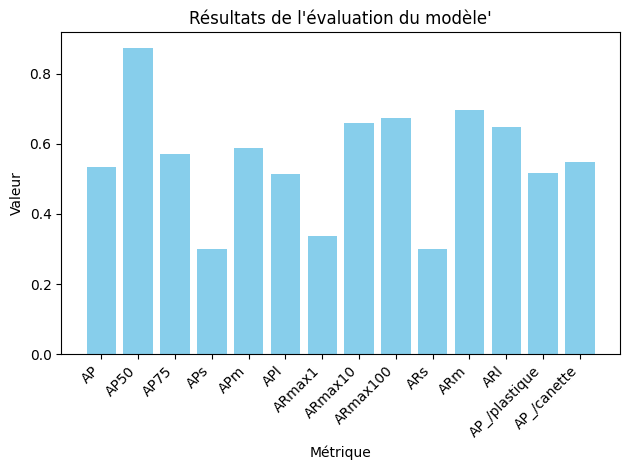

In [9]:
# https://cocodataset.org/#detection-eval
# val_loss, val_accuracy = model.evaluate(val_data)

evaluation = model.evaluate(val_data)

def plotEvaluation(eval, title="Résultats de l\'évaluation du modèle'"):
    import matplotlib.pyplot as plt
    plt.bar(eval.keys(), eval.values(), color='skyblue')
    plt.xlabel('Métrique')
    plt.ylabel('Valeur')
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plotEvaluation(evaluation)

## Export du modèle au format Tensorflow lite

In [18]:
config = QuantizationConfig.for_float16()
model.export(export_dir='bin/', 
             tflite_filename='greengardians.tflite', 
            quantization_config=config
             )
# model.export(export_dir='bin/', 
#              quantization_config=config,
#              export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL])


2024-04-14 19:55:59.392087: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2024-04-14 19:56:21.950732: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-04-14 19:56:21.950780: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2024-04-14 19:56:21.950982: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpf4pucpo6
2024-04-14 19:56:22.083338: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2024-04-14 19:56:22.083375: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpf4pucpo6
2024-04-14 19:56:22.515526: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-04-14 19:56:26.350691: I tensorflow/cc/saved_

Estimated count of arithmetic ops: 13.698 G  ops, equivalently 6.849 G  MACs


## Evaluation du modèle entrainé

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


16/16 [==============================] - 253s 16s/step



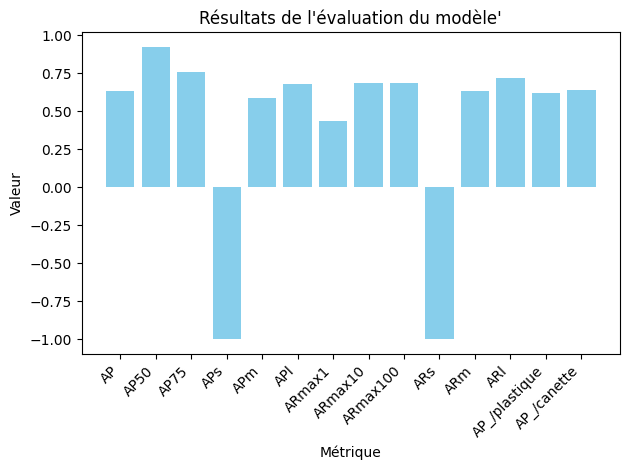

In [11]:
model_path = 'bin/greengardians.tflite'
evaluation_lite = model.evaluate_tflite(model_path, test_data)

plotEvaluation(evaluation_lite)

In [12]:
# NUMBER_OF_TPUS =  2

# !edgetpu_compiler 'bin/greengardians.tflite' --num_segments=$NUMBER_OF_TPUS

## Utilitaires

In [13]:
import cv2

from PIL import Image

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# classes = {0: "plastique", 1: "canette"}
print('classes', classes)

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)


  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])


  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results

def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  print('results', results)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

classes ['plastique', 'canette']


## Prediction

In [14]:
# Load the TFLite model
import os, random
from pathlib import Path
model_path = 'bin/greengardians.tflite'

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# # Run inference and draw detection result on the local copy of the original file
DETECTION_THRESHOLD = 0.5
          
PROJECT_FOLDER = Path(Path.cwd())
image_folder = str(PROJECT_FOLDER) + '/datasets/dataset.voc/test/'
# imageToPredict = 'datasets/dataset.voc/test/IMG_20231025_095509_jpg.rf.c83cb3628dda974ef28a37ce404b9ab7.jpg'
                                                          
l_detection_result_image = []
files = [image_folder +'/'+ f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# imageToPredict = 'datasets/dataset.voc/test/IMG_20231025_095509_jpg.rf.c83cb3628dda974ef28a37ce404b9ab7.jpg'
imageToPredict = random.choice(files)
print(imageToPredict)
detection_result_image = run_odt_and_draw_results(
        imageToPredict,
        interpreter,
        threshold=DETECTION_THRESHOLD
)
# for file in files:
#     detection_result_image = run_odt_and_draw_results(
#         file,
#         interpreter,
#         threshold=DETECTION_THRESHOLD
#     )
#     l_detection_result_image.append(detection_result_image)

/home/charles/web/alyra/villepropre/vp-server/train/datasets/dataset.voc/test//IMG_20231025_095831_jpg.rf.6d8b19314ae50b80d846813b15ce03f8.jpg
results [{'bounding_box': array([0.3531137, 0.5489751, 0.6094619, 0.7468078], dtype=float32), 'class_id': 1.0, 'score': 0.87109375}, {'bounding_box': array([0.26512876, 0.27983716, 0.55047476, 0.4694048 ], dtype=float32), 'class_id': 1.0, 'score': 0.71484375}, {'bounding_box': array([-0.00199068,  0.7689454 ,  0.6395478 ,  0.99664384], dtype=float32), 'class_id': 0.0, 'score': 0.51171875}]


TypeError: Image data of dtype <U142 cannot be converted to float

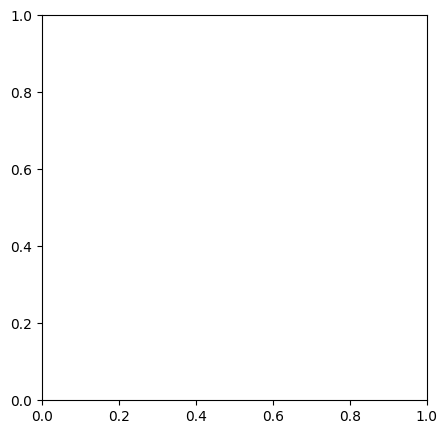

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.imshow(imageToPredict)
plt.show()
plt.close()
# test_validation_folder = str(PROJECT_FOLDER) + '/datasets/dataset.voc/test_val/'

# # Show all the detection result
# for image in l_detection_result_image:
#     plt.figure(figsize=(5, 5))
#     plt.imshow(image)
#     plt.show()
#     # Save the image in the validation folder    
#     plt.close()